In [56]:
import pickle
from os.path import exists 
import pandas as pd
import plotly.express as px
from feature_engine.selection import DropCorrelatedFeatures
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from skopt.space import Real, Integer, Categorical
from skopt.plots import plot_evaluations, plot_convergence, plot_objective
from skopt.utils import dump, load

from utils.data_preparation import *
from utils.data_exploration import *
from utils.training import *
from pandas_profiling import ProfileReport
import shap

from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier


task = "cyp2c19"

# Data

## Molecular Fingerprints

Machine learning models almost always take arrays of numbers as their inputs. If we want to process molecules with them, we somehow need to represent each molecule as one or more arrays of numbers.

Many (but not all) types of models require their inputs to have a fixed size. This can be a challenge for molecules, since different molecules have different numbers of atoms. If we want to use these types of models, we somehow need to represent variable sized molecules with fixed sized arrays.

Fingerprints are designed to address these problems. A fingerprint is a fixed length array, where different elements indicate the presence of different features in the molecule. If two molecules have similar fingerprints, that indicates they contain many of the same features, and therefore will likely have similar chemistry.

RDKit supports a particular type of fingerprint called an "Extended Connectivity Fingerprint", or "ECFP" for short. They also are sometimes called "circular fingerprints". The ECFP algorithm begins by classifying atoms based only on their direct properties and bonds. Each unique pattern is a feature. For example, "carbon atom bonded to two hydrogens and two heavy atoms" would be a feature, and a particular element of the fingerprint is set to 1 for any molecule that contains that feature. It then iteratively identifies new features by looking at larger circular neighborhoods. One specific feature bonded to two other specific features becomes a higher level feature, and the corresponding element is set for any molecule that contains it. This continues for a fixed number of iterations, most often two.

source: [https://www.kaggle.com/code/shivanshuman/molecular-fingerprints]

## Loading the Dataset + Data Cleaning

In terms of data cleaning the following steps are performed:

- Normalization of smiles strings before calculating descriptors and fingerprints
  - Normalization includes the removal of metals in the molecule (<span style="color:cyan">TODO</span> Why?)
- Removal of small molecules
  - For example: 
    - Molecules consisting of a single atom (<span style="color:cyan">TODO</span> Why?)
    - Molecules that are metals
- Removing of NaN values by either removing the corresponding column or row. 
  - For molecular descriptors it doesn't make much sense to fill missing values with some default value or mean of the existing values


In the first iteration we will focus on using the Morgan fingerprints. If there is time later we will explore other fingerprints and compare. 

In [57]:
data = data_preprocessing(task)
# we only use Morgan fingerprints
data = data.drop(["MACCS_FP", "ATOMPAIR_FP"], axis=1)
data = select_druglike_molecules(data)
# data = remove_small_molecules(data)

# turn string of fingerprints into single features
morgan_fingerprint_df = pd.DataFrame(
    convert_strings_to_int_array(data["Morgan_FP"].values), index=data.index
)
data = data.merge(morgan_fingerprint_df, left_index=True, right_index=True)

data

Dataset already exists, returning data/cyp2c19/raw_dataset.csv.
Numbe of molecules before druglikeliness selection: 12665
Numbe of druglike molecules: 12210


,Y,Drug,Drug_ID,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,CCCC(=O)Nc1ccc(N2CCN(CC)CC2)c(Cl)c1,6602638.0,11.609395,0.039701,11.609395,0.039701,0.906872,309.841,285.649,...,0,0,0,0,0,0,0,0,0,0
1,1,CC(=O)N(c1ccc2oc(=O)sc2c1)S(=O)(=O)c1cccs1,644675.0,12.610408,-3.973681,12.610408,0.072387,0.720977,355.418,346.346,...,0,0,0,0,0,0,0,0,0,0
2,1,Clc1ccccc1-c1nc(-c2ccccc2)n[nH]1,644851.0,6.126257,0.660427,6.126257,0.660427,0.756902,255.708,245.628,...,0,0,0,0,0,0,0,0,0,0
3,1,COc1ccccc1C(c1nnnn1C(C)(C)C)N1CCN(Cc2ccncc2)CC1,644890.0,5.719940,-0.219974,5.719940,0.075509,0.605920,421.549,390.301,...,0,0,0,0,0,0,0,0,0,0
4,1,COc1ccccc1CNC(=O)Cn1nnc(-c2ccncc2)n1,644968.0,12.040635,-0.208718,12.040635,0.006714,0.728361,324.344,308.216,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12660,0,CCN1C(=O)[C@@H]2[C@@H](CC[C@@H]3C(=O)C=C[C@@H]...,16758814.0,12.346902,-0.801800,12.346902,0.024123,0.682518,263.293,246.157,...,0,0,0,0,0,0,0,0,0,0
12661,0,O=C1[C@H]2CC=C3[C@@H]([C@H](O)[C@H]4O[C@@H]4C3...,16758816.0,13.390757,-1.019880,13.390757,0.162294,0.455270,397.427,374.243,...,0,0,0,0,0,0,0,0,0,0
12662,1,CCN1C(=O)[C@H]2CC=C3[C@@H]([C@H](O)[C@H]4O[C@@...,16758817.0,12.817440,-0.985371,12.817440,0.131139,0.406549,335.356,314.188,...,0,0,0,0,0,0,0,0,0,0
12663,0,C[C@H](c1ccccc1)N1C(=O)[C@@H]2[C@@H](CC[C@@H]3...,16758818.0,13.179767,-1.161112,13.179767,0.077392,0.772281,357.406,334.222,...,0,0,0,0,0,0,0,0,0,0


### Remove missing values 
Since less than 1% of molecules have missing values we simply remove those molecules since using a default value doesn't make much sense for the shown descriptors.

In [58]:
data_nan = extract_null(data)
print(
    f"There are {data_nan.shape[0]} ({data_nan.shape[0]/data.shape[0]*100:.2f}%) molecules and {data_nan.shape[1]-3} descriptors with missing values."
)
data = data.drop(data_nan.index)
print("Data shape after dropping NaN samples:", data.shape)
data_nan

There are 35 (0.29%) molecules and 12 descriptors with missing values.
Data shape after dropping NaN samples: (12175, 2260)


,Drug,Drug_ID,Y,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW
3855,O=[As](O)(O)c1ccc([As](=O)(O)O)cc1,224250.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3856,O=S(=O)(Nc1nccs1)c1ccc([As](=O)(O)O)cc1,224267.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3857,O=C(O)CNC(=O)c1ccc([As](=O)(O)O)cc1,224270.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3858,O=[As](O)(O)c1ccc(N=Nc2ccc(O)cc2)cc1,224279.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3859,NC(=O)c1ccc(C(=O)Nc2ccc([As](=O)(O)O)cc2)cc1,224295.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3863,NC(=O)Nc1cc([As](=O)(O)O)cc(I)c1O,224575.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3879,NS(=O)(=O)Cc1ccc([As](=O)(O)O)cc1,224907.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3880,O=C(O)[C@@H](O)c1ccc([As](=O)(O)O)cc1,3246047.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3881,O=S(=O)(NCCO)c1ccc([Sb](=O)(O)O)cc1,224913.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3882,O=C(O)/C=C\c1cccc([Sb](=O)(O)O)c1,5771529.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Train-Validation-Test split


In [59]:
# split data in train, val, test
datasets = dataset_split(data.drop(["Drug", "Drug_ID", "Morgan_FP"], axis=1))
# The descriptors include discrete and continuous data, distinguished by their dtype.
feature_groups = get_feature_groups(datasets, morgan_fingerprint_df)

Splitting the data into 70.00% training, 10.00% validation, and 20.00% testing.
Unique Datatypes: {dtype('int32'), dtype('int64'), dtype('float64')}


## Dataset Exoploration

,Y,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
count,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,...,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.00000,8522.000000,8522.000000,8522.000000,8522.000000
mean,0.461981,11.222147,-0.825236,11.222147,0.200832,0.629437,342.136913,322.791049,341.760127,126.033091,...,0.013964,0.003051,0.015020,0.007627,0.024290,0.00927,0.013612,0.006102,0.010796,0.004224
std,0.498582,2.693377,1.439234,2.693377,0.224219,0.174060,85.287027,81.294685,85.183894,31.633750,...,0.117348,0.055154,0.121639,0.087006,0.153957,0.09584,0.115880,0.077880,0.103346,0.064861
min,0.000000,0.000000,-7.603763,0.000000,0.000000,0.086171,17.031000,14.007000,17.026549,8.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,10.903072,-0.965024,10.903072,0.049009,0.501267,287.751000,270.226000,287.169202,106.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,12.236159,-0.372411,12.236159,0.125293,0.647325,342.348500,323.226000,342.009207,126.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,12.869220,-0.041564,12.869220,0.248257,0.776694,399.537250,378.256000,399.171183,146.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
max,1.000000,17.398044,3.500000,17.398044,3.500000,0.946895,776.872000,765.784000,776.686700,292.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


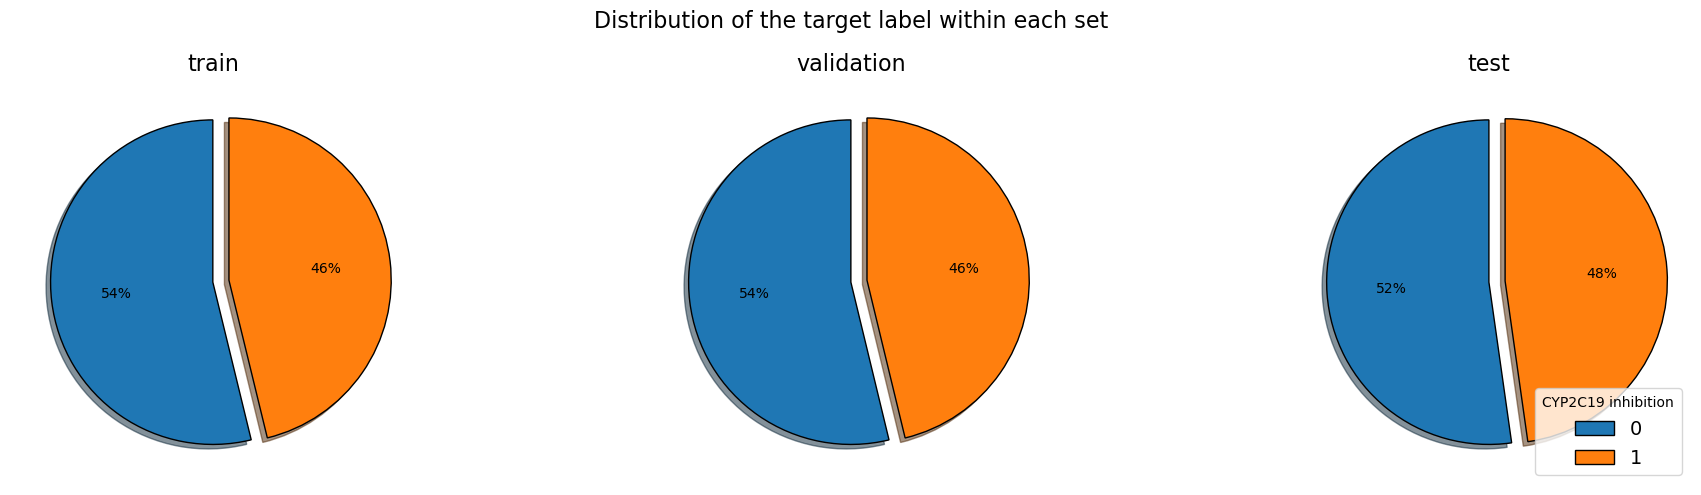

In [60]:
plot_counts(
    [datasets["train"]["Y"], datasets["val"]["Y"], datasets["test"]["Y"]],
    suptitle="Distribution of the target label within each set",
    titles=["train", "validation", "test"],
    legend_title="CYP2C19 inhibition",
    kind="pie",
)
datasets["train"].describe()

### Continuous Data

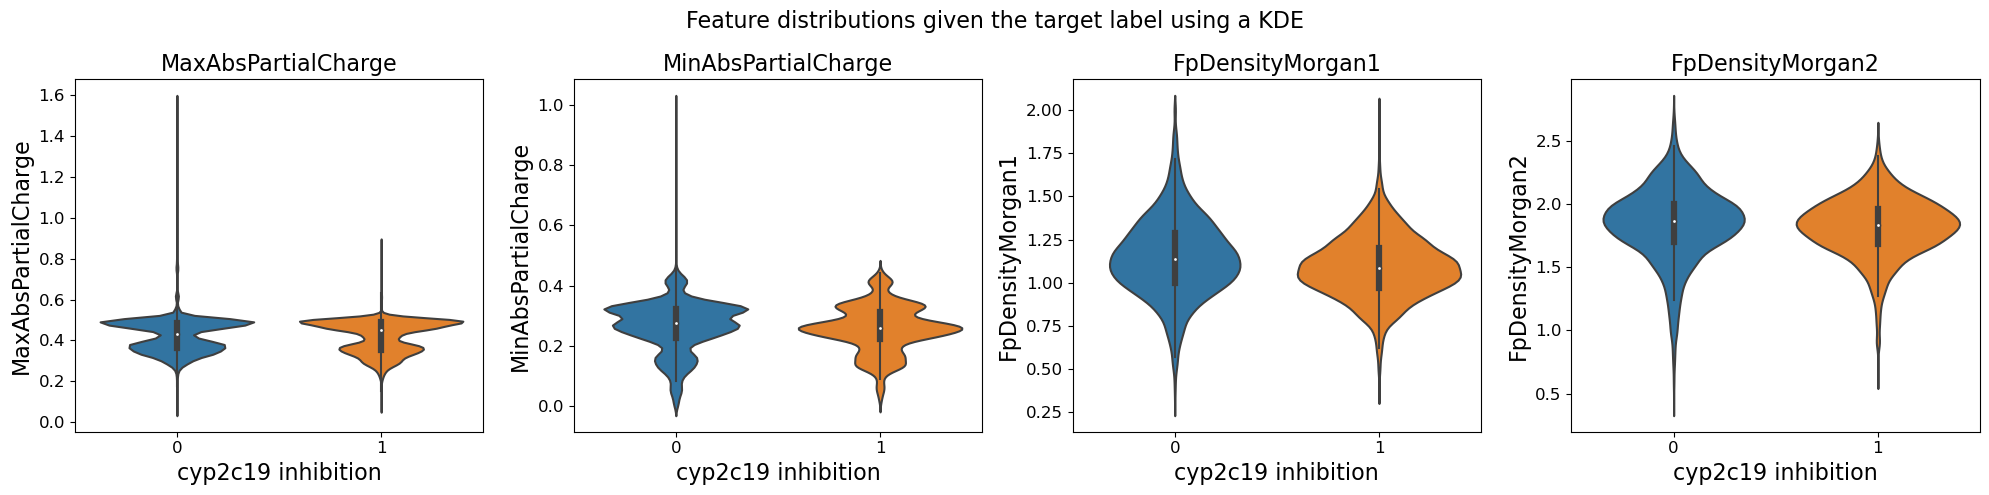

In [61]:
# Correlation matrix of descriptors
cor_matrix = datasets["train"][feature_groups.continuous].corr()
top_cor_matrix = cor_matrix.where(
    np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool)
)
fig = px.imshow(
    top_cor_matrix,
    color_continuous_scale="RdBu_r",
    title=f"{task} inhibition\nDescriptor correlation",
)

fig.write_html(f"data/{task}/descriptor_correlation.html")

# violin plots
feature_distributions(
    data=datasets["train"][["Y"] + feature_groups.continuous],
    features=feature_groups.continuous[10:14],
    suptitle="Feature distributions given the target label using a KDE",
    task=f"{task} inhibition",
)

### Discrete Data

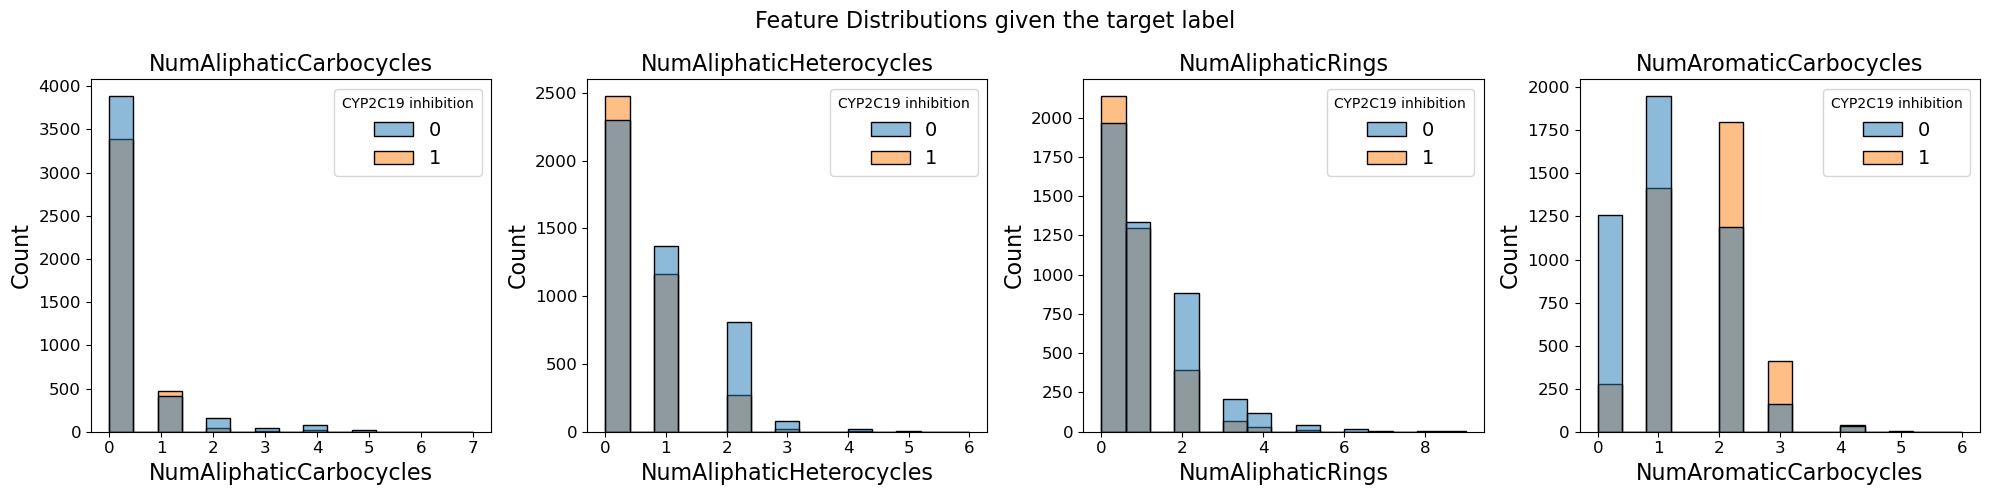

In [62]:
feature_distributions(
    data=datasets["train"][["Y"] + feature_groups.discrete],
    features=feature_groups.discrete[5:9],
    kind="hist",
    suptitle="Feature Distributions given the target label",
    task="CYP2C19 inhibition",
)

## Feature Selection

There are in total 208 different descriptors. Relevant descriptors for the task of predicting CYP inhibition need to be selected to reduce the number of input variables to the clasical machine learning algorithm. Feature selection can either be performed unsupervised (without knowledge of the target label) or supervised.

**Note:** Some machine learning models have some form of feature selection inbuild, e.g. tree-based models. In those cases we don't perform feature selection upfront.

### Variance Threshold

Having a look at for example the number of radical electrons (NumRadicalElectrons). We can see that all datapoints in the dataset have a value of 0 (min=max=0.0). 

In the area of feature selection there is a method called **variance threshold**: Given a threshold all features with a variance below this threshold will be removed. (<span style="color:cyan">TODO</span> Add better source; https://medium.com/nerd-for-tech/removing-constant-variables-feature-selection-463e2d6a30d9#:~:text=Variance%20Threshold%20is%20a%20feature,be%20used%20for%20unsupervised%20learning.)

The default value is usually 0 (removing constant features as they obviously bring no additional information to our model). If the variance threshold is greater than zero but still small we are removing quasi-constant features. The arguments against using a variance greater than 0 say that you may be moving variables that, although they have low variance, might actually be extremely powerful in explaining your target (dependent) variable.

For now, we are exploring which features are constant in our dataset.

In [63]:
print("Features with 0 variance:\n")
for index, n_unique in zip(
    datasets["train"].nunique(axis=0).index, datasets["train"].nunique(axis=0)
):
    if n_unique == 1:
        print(index)
        
print("\n", summarize_descriptors(["NumRadicalElectrons"]))
datasets["train"]["NumRadicalElectrons"].describe()

Features with 0 variance:

NumRadicalElectrons
SMR_VSA8
SlogP_VSA9
fr_prisulfonamd

 {'NumRadicalElectrons': 'The number of radical electrons the molecule has (says nothing about spin state)'}


count    8522.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: NumRadicalElectrons, dtype: float64

### Drop Correlated Features

As shown in the correlation matrix there are some feature groups in our dataset with high correlation. In order to escape the curse of dimensionality we want to remove features with a high correlation to other features - out of two features with high correlation only one remains. When features are collinear, permutating one feature will have little effect on the models performance because it can get the same information from a correlated feature. One way to handle multicollinear features is by performing hierarchical clustering on the Spearman rank-order correlations, picking a threshold, and keeping a single feature from each cluster. Source: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html

The y-axis of the following dendrogram is a measure of closeness of either individual data points or clusters. 


The idea of dropping highly correlated features is also applied by the following method: [DropCorrelatedFeatures](https://feature-engine.readthedocs.io/en/1.1.x/selection/DropCorrelatedFeatures.html) from the feature_engine. Here, features are removed on first found first removed basis, without any further insight using pearson correlation score.

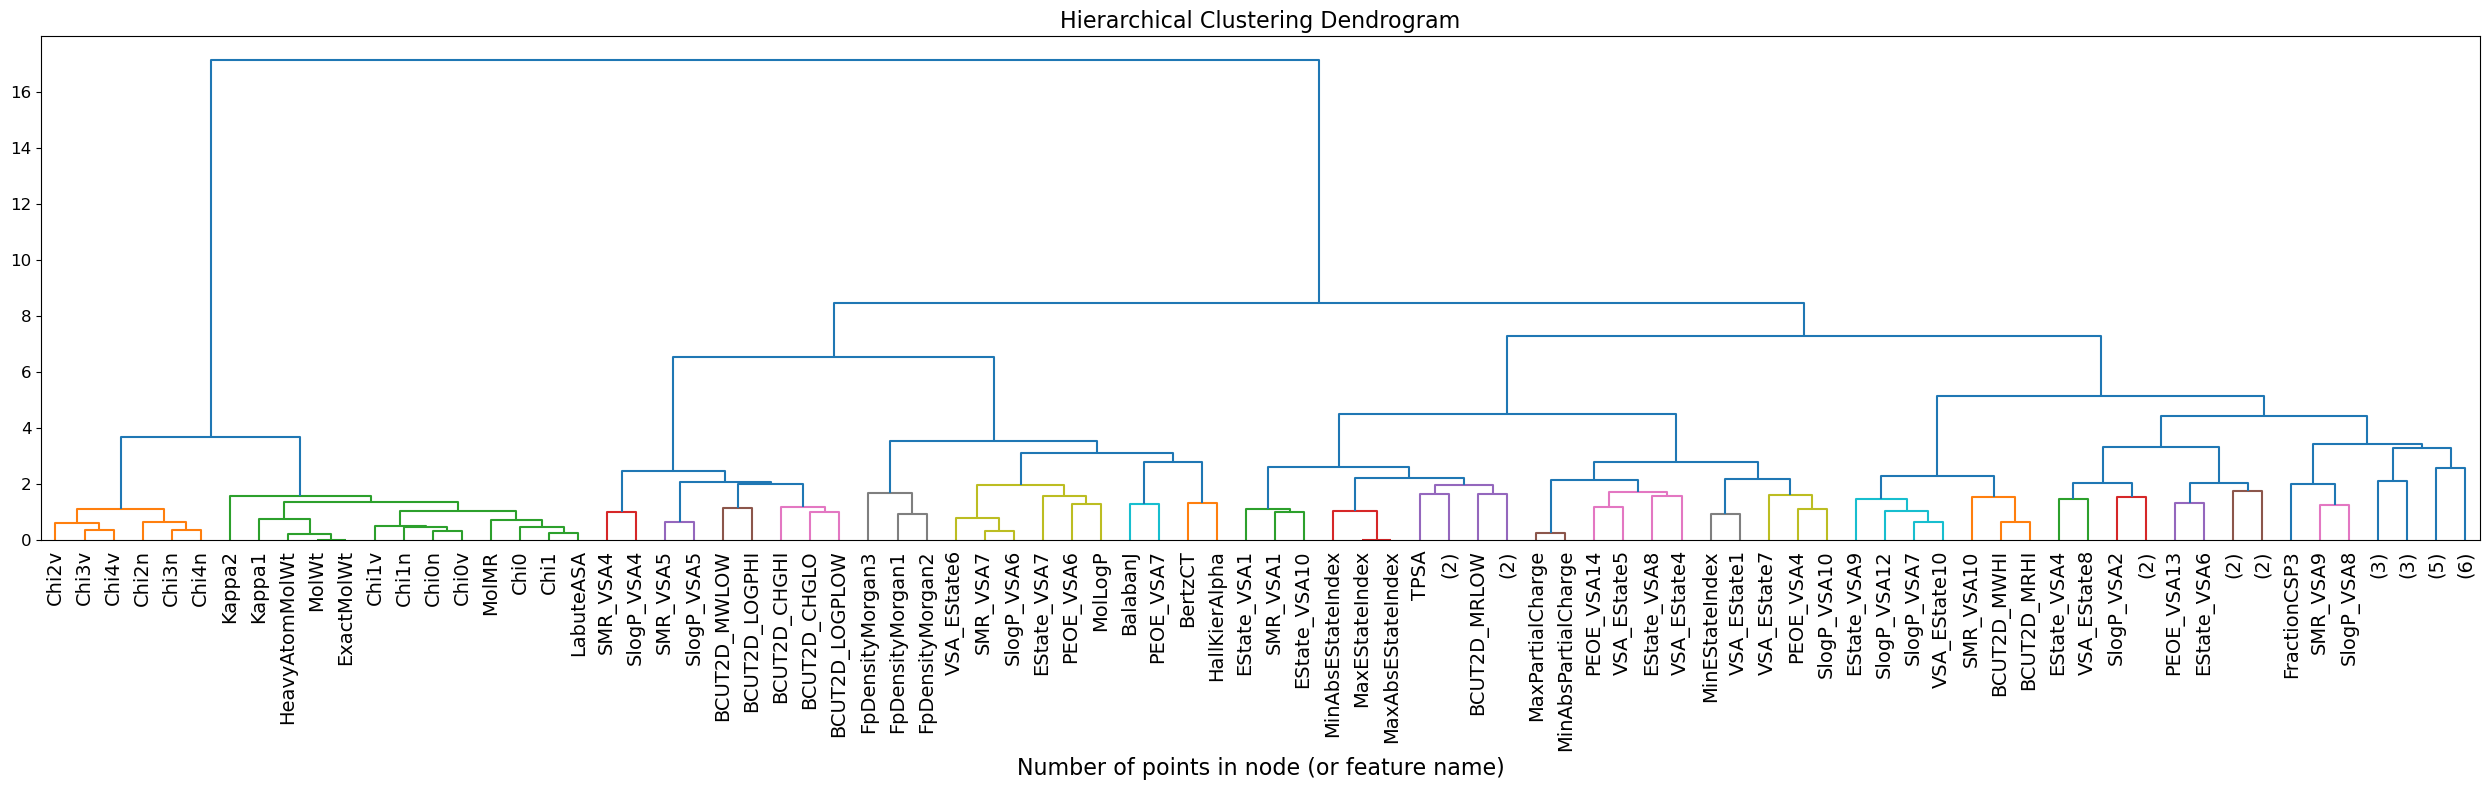

In [64]:
plot_dendrogram(cor_matrix, level=7, color_threshold=2)

In [65]:
# Exploring DropCorrelatedFeatures

drop_corr_features = DropCorrelatedFeatures(threshold=0.8)
print(
    "Number of features before transformation:",
    datasets["train"][feature_groups.continuous].shape[1],
)
reduced_continuous_data = drop_corr_features.fit_transform(
    datasets["train"][feature_groups.continuous]
)
print("Number of features after transformation:", reduced_continuous_data.shape[1])

# Correlation matrix of descriptors
reduced_cor_matrix = reduced_continuous_data.corr()
reduced_top_cor_matrix = reduced_cor_matrix.where(
    np.triu(np.ones(reduced_cor_matrix.shape), k=1).astype(np.bool)
)
fig = px.imshow(
    reduced_top_cor_matrix,
    color_continuous_scale="RdBu_r",
    title=f"{task} inhibition\nDescriptor correlation after dropping highly correlated features",
)

fig.write_html(f"data/{task.lower()}/descriptor_correlation_pruned.html")

Number of features before transformation: 104
Number of features after transformation: 76


    **NOTE:** We don't do the following anymore.

    ### Select Percentile

    For discrete features and fingerprints we are using a mutual information statistical test and apply multivariate feature selection.

    ## Dimensionality reduction

    ### PCA

    For continuous data we will perform a PCA to reduce the dimensionality of the features. Since PCA should only be applied to continuous data we will split our preprocessing pipeline into three parts:

    1. Preprocessing of continuous descriptors
    2. Preprocessing of discrete descriptors
    3. Preprocessing of the fingerprint

    See DataPreprocessing in utils/training.py for the exact preprocessing pipelines.

## Feature Normalization

For continuous features and discrete descriptors we are using a MinMaxScaler. Since fingerprint features are binary we don't normalize them.

## Training

Use ```utils/training/BayesianOptimizer```. To do random search simply set ```n_calls=n_initial_points``` in ```self.optimize()```.

### Dummy Classifier

Accuracy: 53.78%
F1-score: 0.00%
Matthews correlation coefficient: 0.0%


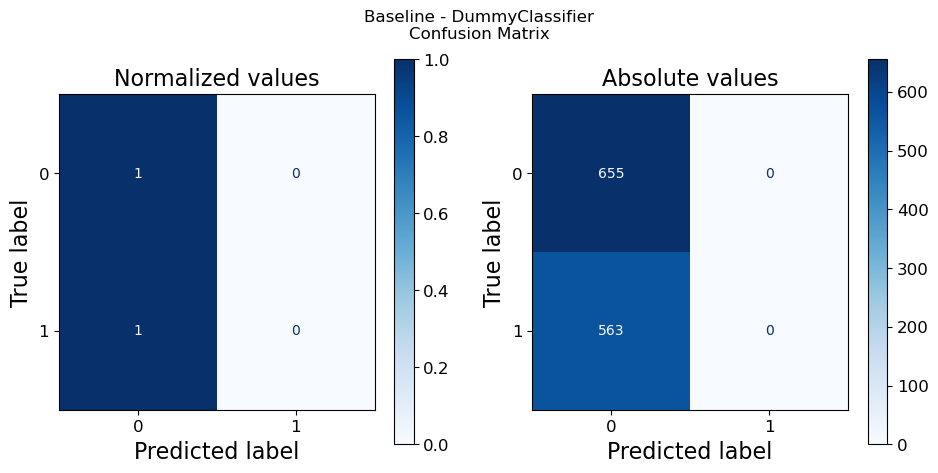

In [24]:
get_baseline(datasets)

## SVC

In [67]:
svc_0 = BayesianOptimization(
    model=SVC,
    file_name=f"{task}/svc_0", 
    model_params=[
        Real(name="C", low=0.1, high=4.0)
    ],
    fix_model_params={"class_weight": "balanced"},
    datasets=datasets,
    feature_groups=feature_groups,
    main_metric="mcc"
)

svc_0.optimize(n_calls=20) 
svc_0.pretty_results()

Iteration No: 1 started. Evaluating function at random point.
Number of features after preprocessing:             399/2256
Save results.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 15.9824
Function value obtained: -0.6312
Current minimum: -0.6312
Iteration No: 2 started. Evaluating function at random point.
Number of features after preprocessing:             613/2256
Save results.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 23.0626
Function value obtained: -0.6335
Current minimum: -0.6335
Iteration No: 3 started. Evaluating function at random point.
Number of features after preprocessing:             1181/2256
Save results.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 42.3992
Function value obtained: -0.6462
Current minimum: -0.6462
Iteration No: 4 started. Evaluating function at random point.
Number of features after preprocessing:             718/2256
Save results.
Iteration No: 4 ended. Evaluation done at random 

,C,var_threshold_continuous,var_threshold_discrete,var_threshold_fingerprint,corr_threshold,val_accuracy,val_f1,val_precision,val_recall,val_mcc
12,1.306832,0.016017,0.027299,0.002842,0.972394,0.826765,0.820731,0.786645,0.857904,0.656047
17,1.190530,0.000593,0.020978,0.006257,0.968714,0.825123,0.819031,0.785016,0.856128,0.652753
16,1.263985,0.013221,0.016981,0.007968,0.993856,0.825123,0.819031,0.785016,0.856128,0.652753
15,1.589366,0.012121,0.023405,0.008835,0.973557,0.824302,0.818027,0.784666,0.854352,0.650974
13,1.225968,0.013923,0.042815,0.010222,0.970425,0.824302,0.818027,0.784666,0.854352,0.650974


Number of features after preprocessing:             1930/2256
Accuracy: 82.68%
F1-score: 82.07%
Matthews correlation coefficient: 0.6560467308514514%


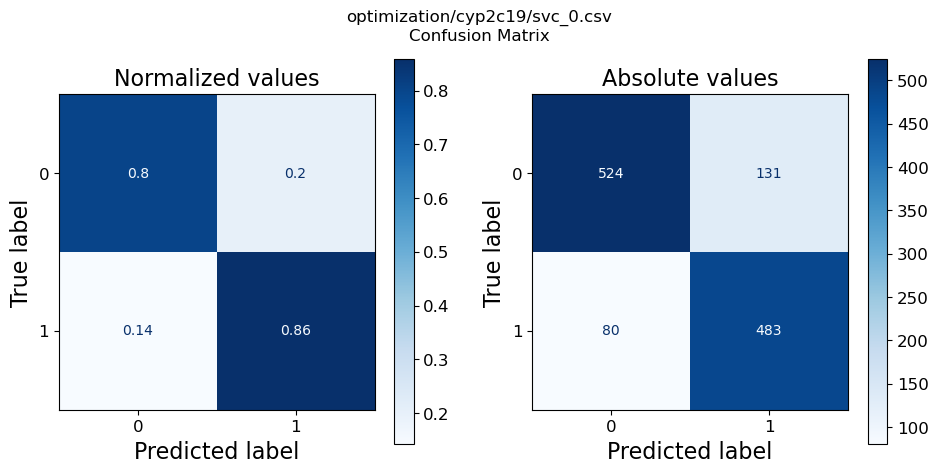

In [68]:
metric_columns = list(svc_0.results.filter(regex='val_'))
# Position 0
best_params_0 = svc_0.results.sort_values("val_mcc", ascending=False).drop(metric_columns, axis=1).iloc[0]
svc_0_y_pred, svc_0_y_pred_proba = svc_0.get_predictions(best_params_0)

conf_matrix(datasets["val"]["Y"], svc_0_y_pred, svc_0.file_loc)

del svc_0

## RandomForestClassifier
For a random forest classifier we don't need to do any preprocessing. A decision tree based classifier is scale invariant and has inbuild feature selection.


In [70]:
x_train = datasets["train"].drop("Y", axis=1)
y_train = datasets["train"]["Y"]
x_val = datasets["val"].drop("Y", axis=1)
y_val = datasets["val"]["Y"]

# drop constant features
preprocessing_pipe = DataPreprocessing(feature_groups, corr_threshold=1.0)
preprocessing_pipe.fit(x_train, y_train)
x_train_preprocessed = preprocessing_pipe.transform(x_train)
x_val_preprocessed = preprocessing_pipe.transform(x_val)

rf_max_depth = train_random_forest_depth(
    f"optimization/{task}/rf_max_depth",
    x_train_preprocessed,
    x_val_preprocessed,
    y_train,
    y_val,
    class_weight="balanced"
)

metric_columns = list(rf_max_depth.filter(regex="val_"))

pretty_print_df(
    rf_max_depth.sort_values("val_mcc", ascending=False), subset=metric_columns, quantile=0.98
)

Completed run 3/60: max_depth=3
Completed run 4/60: max_depth=4
Completed run 5/60: max_depth=5
Completed run 6/60: max_depth=6
Completed run 7/60: max_depth=7
Completed run 8/60: max_depth=8
Completed run 9/60: max_depth=9
Completed run 10/60: max_depth=10
Completed run 11/60: max_depth=11
Completed run 12/60: max_depth=12
Completed run 13/60: max_depth=13
Completed run 14/60: max_depth=14
Completed run 15/60: max_depth=15
Completed run 16/60: max_depth=16
Completed run 17/60: max_depth=17
Completed run 18/60: max_depth=18
Completed run 19/60: max_depth=19
Completed run 20/60: max_depth=20
Completed run 21/60: max_depth=21
Completed run 22/60: max_depth=22
Completed run 23/60: max_depth=23
Completed run 24/60: max_depth=24
Completed run 25/60: max_depth=25
Completed run 26/60: max_depth=26
Completed run 27/60: max_depth=27
Completed run 28/60: max_depth=28
Completed run 29/60: max_depth=29
Completed run 30/60: max_depth=30
Completed run 31/60: max_depth=31
Completed run 32/60: max_dep

,max_depth,val_accuracy,val_f1,val_precision,val_recall,val_mcc,val_roc_auc_score,val_average_precision_score
40,43,0.818555,0.804252,0.802120,0.806394,0.635172,0.883976,0.856784
37,40,0.816913,0.805240,0.792096,0.818828,0.632906,0.884190,0.854812
31,34,0.811987,0.800349,0.785959,0.815275,0.623177,0.883614,0.857390
18,21,0.811166,0.801724,0.778894,0.825933,0.622743,0.880349,0.851327
41,44,0.811987,0.798593,0.790941,0.806394,0.622437,0.881551,0.853934


In [71]:
best_depth = int(rf_max_depth.sort_values("val_mcc", ascending=False).iloc[0]["max_depth"])
best_rf = RandomForestClassifier(max_depth = best_depth, class_weight="balanced", n_jobs=-1)
best_rf.fit(x_train_preprocessed, y_train)
rf_best_y_pred = best_rf.predict(x_val_preprocessed)
rf_best_y_pred_proba = best_rf.predict_proba(x_val_preprocessed)[:,1]


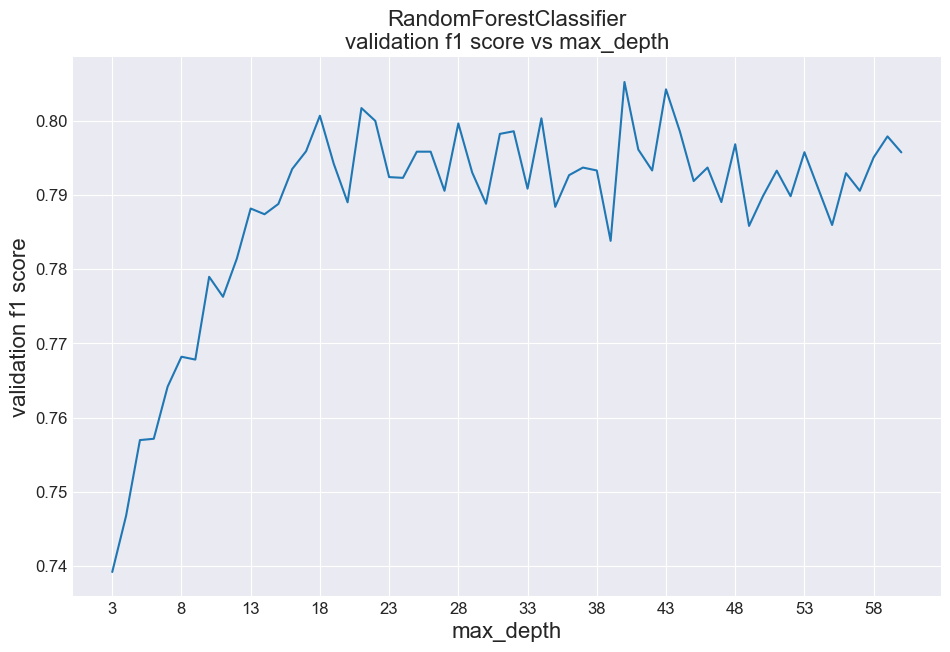

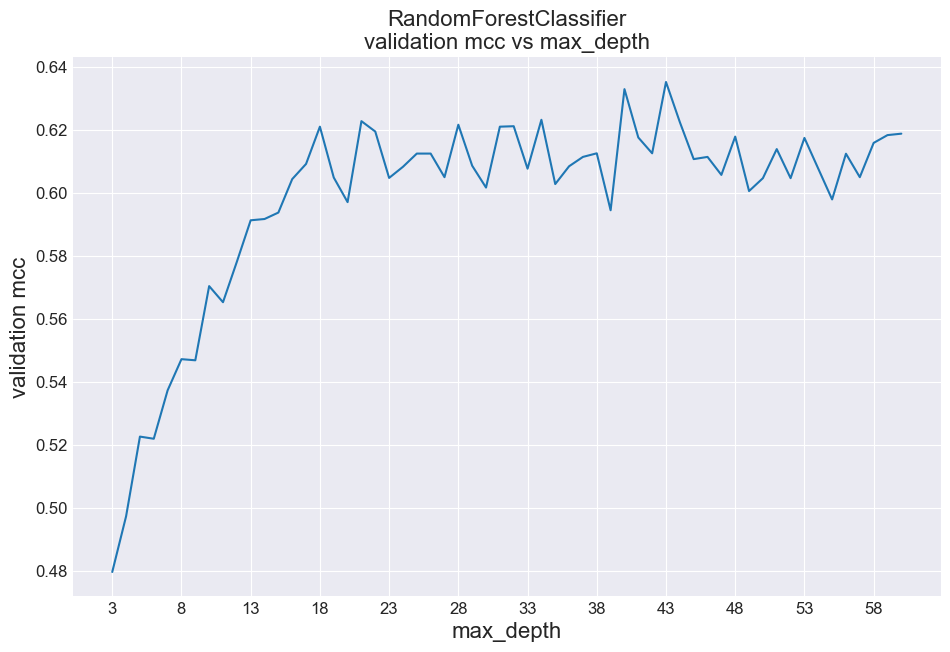

In [72]:
plot_parameter_metric(
    metric_values=rf_max_depth["val_f1"],
    model_name="RandomForestClassifier",
    metric="validation f1 score",
    parameter="max_depth",
    param_values=rf_max_depth["max_depth"],
)

plot_parameter_metric(
    metric_values=rf_max_depth["val_mcc"],
    model_name="RandomForestClassifier",
    metric="validation mcc",
    parameter="max_depth",
    param_values=rf_max_depth["max_depth"],
)

Accuracy: 81.03%
F1-score: 79.79%
Matthews correlation coefficient: 0.6195635947604095%


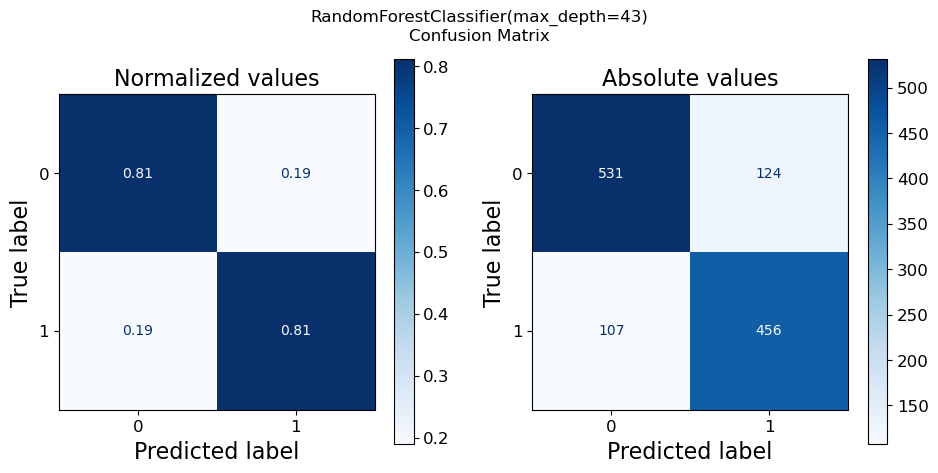

In [73]:
conf_matrix(y_val, rf_best_y_pred, f"RandomForestClassifier(max_depth={best_depth})")


Best Precision-Recall Threshold=0.43624096206344803
Best ROC Threshold=0.5036800706316719


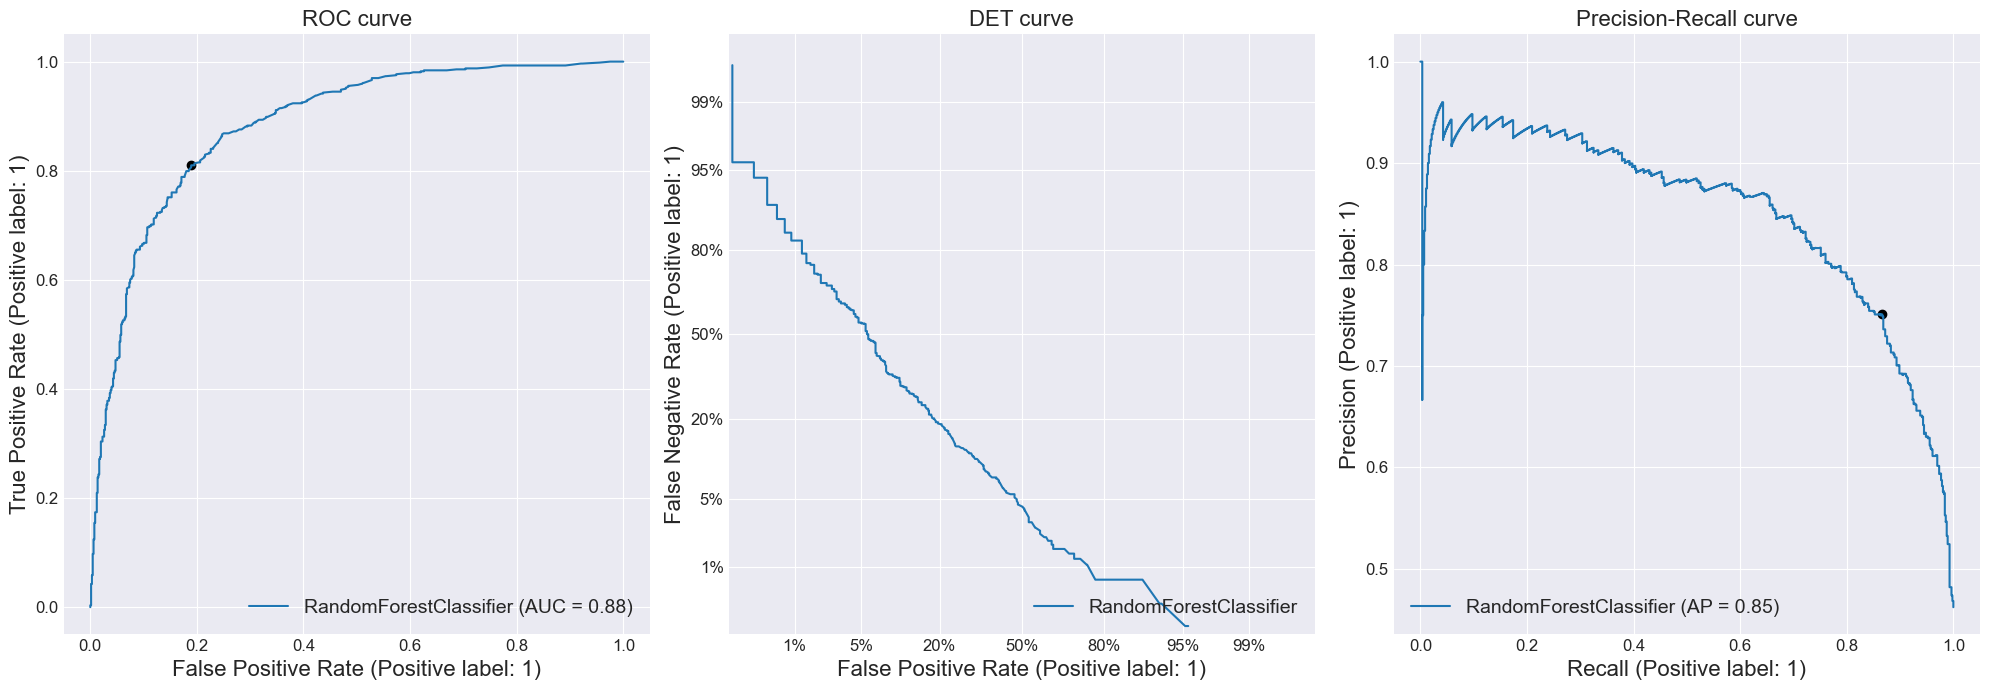

In [74]:
compare_metric_curves(
    {
        "RandomForestClassifier": rf_best_y_pred_proba
    },
    datasets["val"]["Y"],
)

## Logistic Regression


In [75]:
lr_0 = BayesianOptimization(
    model=LogisticRegression,
    file_name=f"{task}/lr_0",
    model_params=[
        Real(name="C", low=0.1, high=4.0),
        Real(name="l1_ratio", low=0, high=1),
    ],
    fix_model_params={
        "solver": "saga",
        "n_jobs": -1,
        "class_weight": "balanced",
        "penalty": "elasticnet",
    },
    datasets=datasets,
    feature_groups=feature_groups,
    main_metric="mcc",
)

lr_0.optimize(n_calls=20)
lr_0.pretty_results()

Iteration No: 1 started. Evaluating function at random point.
Number of features after preprocessing:             286/2256
Save results.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 4.5114
Function value obtained: -0.6028
Current minimum: -0.6028
Iteration No: 2 started. Evaluating function at random point.
Number of features after preprocessing:             382/2256
Save results.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 6.7879
Function value obtained: -0.5911
Current minimum: -0.6028
Iteration No: 3 started. Evaluating function at random point.
Number of features after preprocessing:             451/2256
Save results.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 6.9578
Function value obtained: -0.5922
Current minimum: -0.6028
Iteration No: 4 started. Evaluating function at random point.
Number of features after preprocessing:             1314/2256
Save results.
Iteration No: 4 ended. Evaluation done at random poi

,C,l1_ratio,var_threshold_continuous,var_threshold_discrete,var_threshold_fingerprint,corr_threshold,val_accuracy,val_f1,val_precision,val_recall,val_mcc,val_roc_auc_score,val_average_precision_score
18,1.200791,0.345715,0.036999,0.035179,0.011004,0.835806,0.812808,0.804795,0.776860,0.834813,0.626924,0.876154,0.848499
19,1.281278,0.333857,0.047293,0.042268,0.011531,0.808701,0.811166,0.804089,0.772504,0.838366,0.624367,0.874891,0.846370
6,1.136349,0.399937,0.003011,0.045750,0.007119,0.836994,0.802135,0.794193,0.764803,0.825933,0.605877,0.874806,0.846268
0,1.121051,0.359290,0.001400,0.027046,0.049815,0.846935,0.800493,0.792839,0.762295,0.825933,0.602832,0.863824,0.811981
13,1.352835,0.763026,0.000448,0.031831,0.007094,0.817512,0.798030,0.789744,0.761120,0.820604,0.597521,0.874671,0.845784


Filtered metric columns ['val_accuracy', 'val_f1', 'val_precision', 'val_recall', 'val_mcc', 'val_roc_auc_score', 'val_average_precision_score']
Number of features after preprocessing:             844/2256
Accuracy: 81.28%
F1-score: 80.48%
Matthews correlation coefficient: 0.6269240958352592%


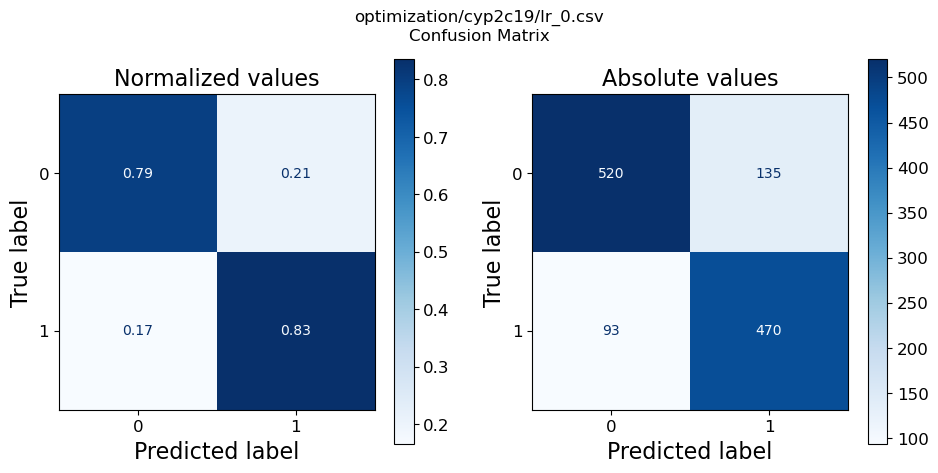

In [76]:
metric_columns = list(lr_0.results.filter(regex='val_'))
print("Filtered metric columns", metric_columns)
# Position 0
best_params_0 = lr_0.results.sort_values("val_mcc", ascending=False).drop(metric_columns, axis=1).iloc[0]
lr_0_best_y_pred, lr_0_best_y_pred_proba = lr_0.get_predictions(best_params_0)

conf_matrix(datasets["val"]["Y"], lr_0_best_y_pred, lr_0.file_loc)

del lr_0 

## CatBoost

In [77]:

n_negative = datasets["train"]["Y"][datasets["train"]["Y"] == 0].count()
n_positive = datasets["train"]["Y"][datasets["train"]["Y"] == 1].count()

catboost_0 = BayesianOptimization(
    model=CatBoostClassifier,
    file_name=f"{task}/catboost_0",
    model_params=[
        Integer(name="max_depth", low=4, high=12),
        Real(name="l2_leaf_reg", low=2., high=10.),
        # Categorical(name="boosting_type", categories=["Ordered", "Plain"]),
        Real(name="scale_pos_weight",low=max(1,n_negative/n_positive-1), high=6),
    ],
    fix_model_params={
        "verbose": 0,
    },
    datasets=datasets,
    feature_groups=feature_groups,
    main_metric="mcc",
)

catboost_0.optimize(n_calls=50)
catboost_0.pretty_results(quantile=0.9)

Iteration No: 1 started. Evaluating function at random point.
Number of features after preprocessing:             409/2256
Save results.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 27.5582
Function value obtained: -0.6082
Current minimum: -0.6082
Iteration No: 2 started. Evaluating function at random point.
Number of features after preprocessing:             377/2256
Save results.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 45.5622
Function value obtained: -0.6063
Current minimum: -0.6082
Iteration No: 3 started. Evaluating function at random point.
Number of features after preprocessing:             350/2256
Save results.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 260.9047
Function value obtained: -0.6098
Current minimum: -0.6098
Iteration No: 4 started. Evaluating function at random point.
Number of features after preprocessing:             368/2256
Save results.
Iteration No: 4 ended. Evaluation done at random 

Number of features after preprocessing:             569/2256
Save results.
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 932.5046
Function value obtained: -0.6019
Current minimum: -0.6459
Iteration No: 31 started. Searching for the next optimal point.
Number of features after preprocessing:             547/2256
Save results.
Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 51.2428
Function value obtained: -0.6383
Current minimum: -0.6459
Iteration No: 32 started. Searching for the next optimal point.
Number of features after preprocessing:             321/2256
Save results.
Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 33.9719
Function value obtained: -0.6342
Current minimum: -0.6459
Iteration No: 33 started. Searching for the next optimal point.
Number of features after preprocessing:             420/2256
Save results.
Iteration No: 33 ended. Search finished for the next optimal point.
T

,max_depth,l2_leaf_reg,scale_pos_weight,var_threshold_continuous,var_threshold_discrete,var_threshold_fingerprint,corr_threshold,val_accuracy,val_f1,val_precision,val_recall,val_mcc,val_roc_auc_score,val_average_precision_score
17,11,3.094738,1.876061,0.023233,0.048048,0.021542,0.996412,0.821839,0.815319,0.782680,0.850799,0.645903,0.898561,0.877980
30,7,3.103817,1.224231,0.013249,0.046310,0.021061,0.996141,0.818555,0.810626,0.783113,0.840142,0.638335,0.899033,0.880065
43,10,3.537479,2.049658,0.006011,0.047049,0.021999,0.997201,0.815271,0.813278,0.763240,0.870337,0.637389,0.896338,0.872702
20,12,6.398635,1.868505,0.012595,0.048906,0.022444,0.996479,0.816913,0.811496,0.774194,0.852575,0.637114,0.894857,0.872574
49,6,5.848770,2.109562,0.023966,0.044260,0.007465,0.999237,0.811166,0.814815,0.745214,0.898757,0.637044,0.895456,0.873301


In [91]:
metric_columns = list(catboost_0.results.filter(regex='val_'))
print("Filtered metric columns", metric_columns)
# Position 0
best_params_0 = catboost_0.results.sort_values("val_mcc", ascending=False).drop(metric_columns, axis=1).iloc[0]
catboost_0_best_y_pred, catboost_0_best_y_pred_proba = catboost_0.get_predictions(best_params_0)

conf_matrix(datasets["val"]["Y"], catboost_0_best_y_pred, catboost_0.file_loc)

NameError: name 'catboost_0' is not defined

Filtered metric columns ['val_accuracy', 'val_f1', 'val_precision', 'val_recall', 'val_mcc', 'val_roc_auc_score', 'val_average_precision_score']
Number of features after preprocessing:             1176/2256
Accuracy: 81.12%
F1-score: 81.48%
Matthews correlation coefficient: 0.6370437675354107%


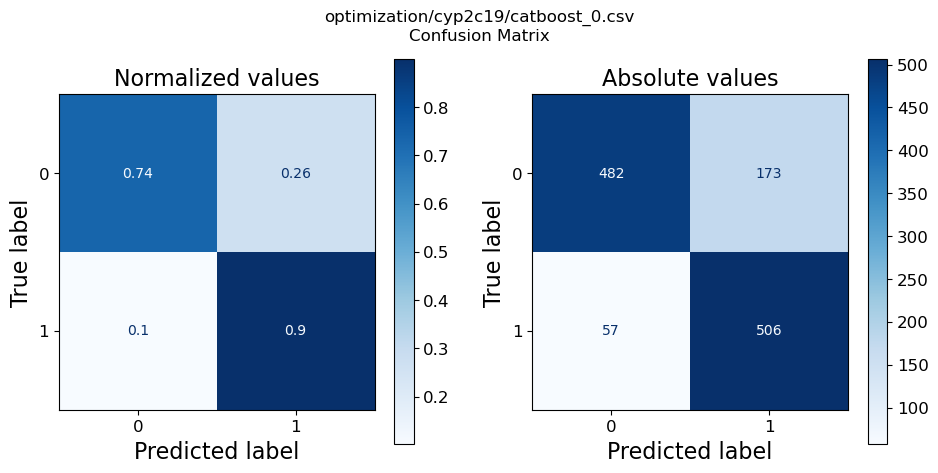

In [79]:
metric_columns = list(catboost_0.results.filter(regex='val_'))
print("Filtered metric columns", metric_columns)
# Position 0
best_params_0 = catboost_0.results.sort_values("val_mcc", ascending=False).drop(metric_columns, axis=1).iloc[4]

catboost_0_best_y_pred, catboost_0_best_y_pred_proba = catboost_0.get_predictions(best_params_0)

conf_matrix(datasets["val"]["Y"], catboost_0_best_y_pred, catboost_0.file_loc)

del catboost_0

## KNN

In [80]:
knn_0 = BayesianOptimization(
    model=KNeighborsClassifier,
    file_name=f"{task}/knn_0", 
    model_params=[
        Integer(name="n_neighbors", low=3, high=60),
    ],
    datasets=datasets,
    feature_groups=feature_groups,
    preprocessing_params=None,
    main_metric="mcc",
    fix_model_params={"weights":"distance"}
)

knn_0.optimize(n_calls=20)
knn_0.pretty_results()

Iteration No: 1 started. Evaluating function at random point.
Number of features after preprocessing:             905/2256
Save results.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.6826
Function value obtained: -0.4878
Current minimum: -0.4878
Iteration No: 2 started. Evaluating function at random point.
Number of features after preprocessing:             430/2256
Save results.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.2533
Function value obtained: -0.4512
Current minimum: -0.4878
Iteration No: 3 started. Evaluating function at random point.
Number of features after preprocessing:             409/2256
Save results.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.0288
Function value obtained: -0.4553
Current minimum: -0.4878
Iteration No: 4 started. Evaluating function at random point.
Number of features after preprocessing:             397/2256
Save results.
Iteration No: 4 ended. Evaluation done at random poin

,n_neighbors,var_threshold_continuous,var_threshold_discrete,var_threshold_fingerprint,corr_threshold,val_accuracy,val_f1,val_precision,val_recall,val_mcc,val_roc_auc_score,val_average_precision_score
14,6,0.002694,0.006849,0.019805,0.851486,0.770115,0.734345,0.788187,0.687389,0.537282,0.842772,0.802766
11,20,0.000177,0.002482,0.046908,0.814355,0.760263,0.719770,0.782881,0.666075,0.517781,0.845819,0.785230
13,7,0.002148,0.009465,0.021662,0.867481,0.759442,0.713587,0.793478,0.648313,0.517567,0.850493,0.807951
17,8,0.000749,0.025338,0.003353,0.848193,0.757800,0.704112,0.808756,0.623446,0.517119,0.846776,0.803574
19,7,0.002990,0.049819,0.021938,0.950283,0.755337,0.710117,0.784946,0.648313,0.508649,0.850280,0.808234


Filtered metric columns ['val_accuracy', 'val_f1', 'val_precision', 'val_recall', 'val_mcc', 'val_roc_auc_score', 'val_average_precision_score']
Number of features after preprocessing:             574/2256
Accuracy: 77.01%
F1-score: 73.43%
Matthews correlation coefficient: 0.5372823421715734%


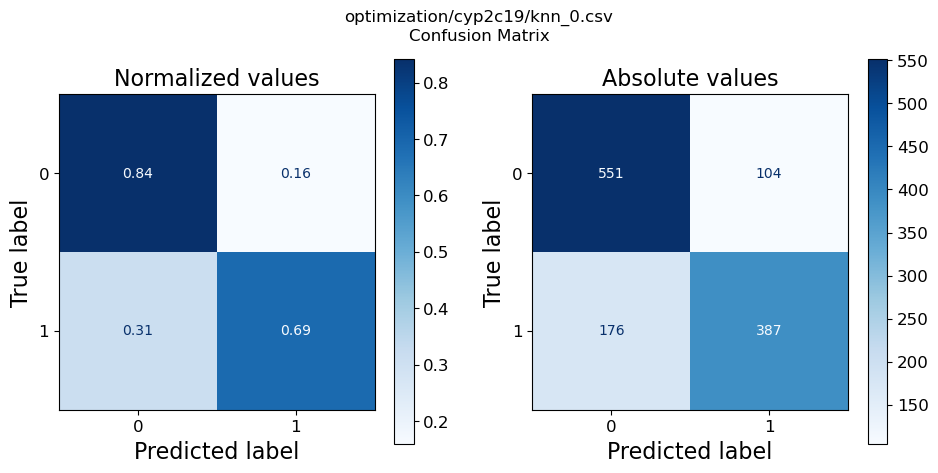

In [81]:
metric_columns = list(knn_0.results.filter(regex='val_'))
print("Filtered metric columns", metric_columns)

best_params_0 = list(knn_0.results.sort_values("val_mcc", ascending=False).drop(metric_columns, axis=1).iloc[0])
best_params_0[0] = int(best_params_0[0])
knn_0_best_y_pred, knn_0_best_y_pred_proba = knn_0.get_predictions(best_params_0)
conf_matrix(datasets["val"]["Y"], knn_0_best_y_pred, knn_0.file_loc)

del knn_0

### XGBOOST Classifier

In [119]:
n_negative = datasets["train"]["Y"][datasets["train"]["Y"] == 0].count()
n_positive = datasets["train"]["Y"][datasets["train"]["Y"] == 1].count()

xgboost_1 = BayesianOptimization(
    model=XGBClassifier,
    file_name=f"{task}/xgboost_1", 
    model_params=[
        Real(name="learning_rate", low=0.01, high=1.0),
        Integer(name="n_estimators", low=100, high=10000),
        Integer(name="max_bin", low=128, high=1024),
        Integer(name="max_depth", low=5, high=50),
        Integer(name="min_child_weight", low=1, high=10),
        Real(name="subsample", low=0.5, high=1),
        Real(name="scale_pos_weight", low=max(1, n_negative / n_positive - 1), high=10),
        Real(name="colsample_bytree", low=0.5, high=1.0),
        Real(name="lambda", low=0.5, high=4.0),
        Real(name="alpha", low=0.5, high=4.0),
    ],
    fix_model_params={"objective": "binary:logistic", "eval_metric": "aucpr"},
    datasets=datasets,
    feature_groups=feature_groups,
    main_metric="mcc",
)

xgboost_1.optimize(n_calls=50)

xgboost_1.pretty_results()

,learning_rate,n_estimators,max_bin,max_depth,min_child_weight,subsample,scale_pos_weight,colsample_bytree,lambda,alpha,var_threshold_continuous,var_threshold_discrete,var_threshold_fingerprint,corr_threshold,val_accuracy,val_f1,val_precision,val_recall,val_mcc,val_roc_auc_score,val_average_precision_score
39,0.129894,9585,938,33,3,0.893406,6.762563,0.602112,2.740051,3.309112,0.047131,0.040823,0.020901,0.811288,0.822660,0.818792,0.775835,0.866785,0.650007,0.894273,0.862256
36,0.346751,8131,748,7,3,0.984571,7.491124,0.627599,3.631406,1.938696,0.043815,0.024833,0.004281,0.842117,0.819376,0.815745,0.771791,0.865009,0.643739,0.888262,0.856588
40,0.118209,8894,741,38,7,0.916317,9.202007,0.854994,1.128865,3.946118,0.041908,0.049478,0.015774,0.858941,0.818555,0.815372,0.769716,0.866785,0.642587,0.892997,0.862340
44,0.084596,9964,987,41,6,0.841138,7.059216,0.903374,0.643628,3.662297,0.019059,0.049665,0.025075,0.827272,0.817734,0.814381,0.769352,0.865009,0.640772,0.890052,0.860492
33,0.046619,9015,1023,39,5,0.905219,6.855434,0.962217,3.887642,0.640467,0.044350,0.047700,0.021554,0.879531,0.817734,0.813758,0.771065,0.861456,0.640122,0.892219,0.864599


Filtered metric columns ['val_accuracy', 'val_f1', 'val_precision', 'val_recall', 'val_mcc', 'val_roc_auc_score', 'val_average_precision_score']
[0.1298937502000295, 9585.0, 938.0, 33.0, 3.0, 0.893405879531621, 6.762563240942471, 0.6021116204302077, 2.7400506056096434, 3.309112351015133, 0.0471306477951028, 0.0408234325165221, 0.0209011003416163, 0.8112880344556693]
[0.1298937502000295, 9585, 938, 33, 3, 0.893405879531621, 6.762563240942471, 0.6021116204302077, 2.7400506056096434, 3.309112351015133, 0.0471306477951028, 0.0408234325165221, 0.0209011003416163, 0.8112880344556693]
Number of features after preprocessing:             521/2256
Accuracy: 82.27%
F1-score: 81.88%
Matthews correlation coefficient: 0.6500072974306675%


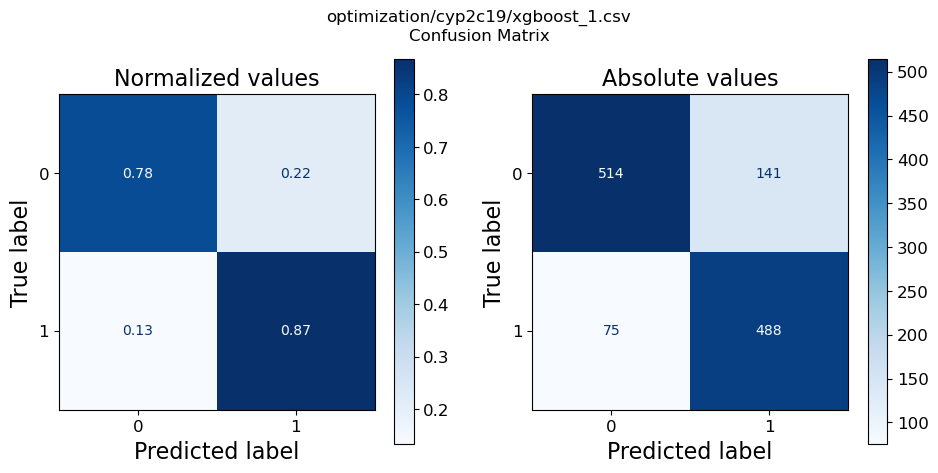

In [120]:

metric_columns = list(xgboost_1.results.filter(regex='val_'))
print("Filtered metric columns", metric_columns)
# Position 0
best_params_1 = list(xgboost_1.results.sort_values("val_mcc", ascending=False).drop(metric_columns, axis=1).iloc[0])
print(best_params_1)
best_params_updated = []
for param in best_params_1:
    if param-int(param) == 0:
        best_params_updated.append(int(param))
    else:
        best_params_updated.append(param)

print(best_params_updated)

xgboost_1_best_y_pred, xgboost_1_best_y_pred_proba = xgboost_1.get_predictions(best_params_updated)

conf_matrix(datasets["val"]["Y"], xgboost_1_best_y_pred, xgboost_1.file_loc)

Best Precision-Recall Threshold=0.523895263671875
Best ROC Threshold=0.523895263671875


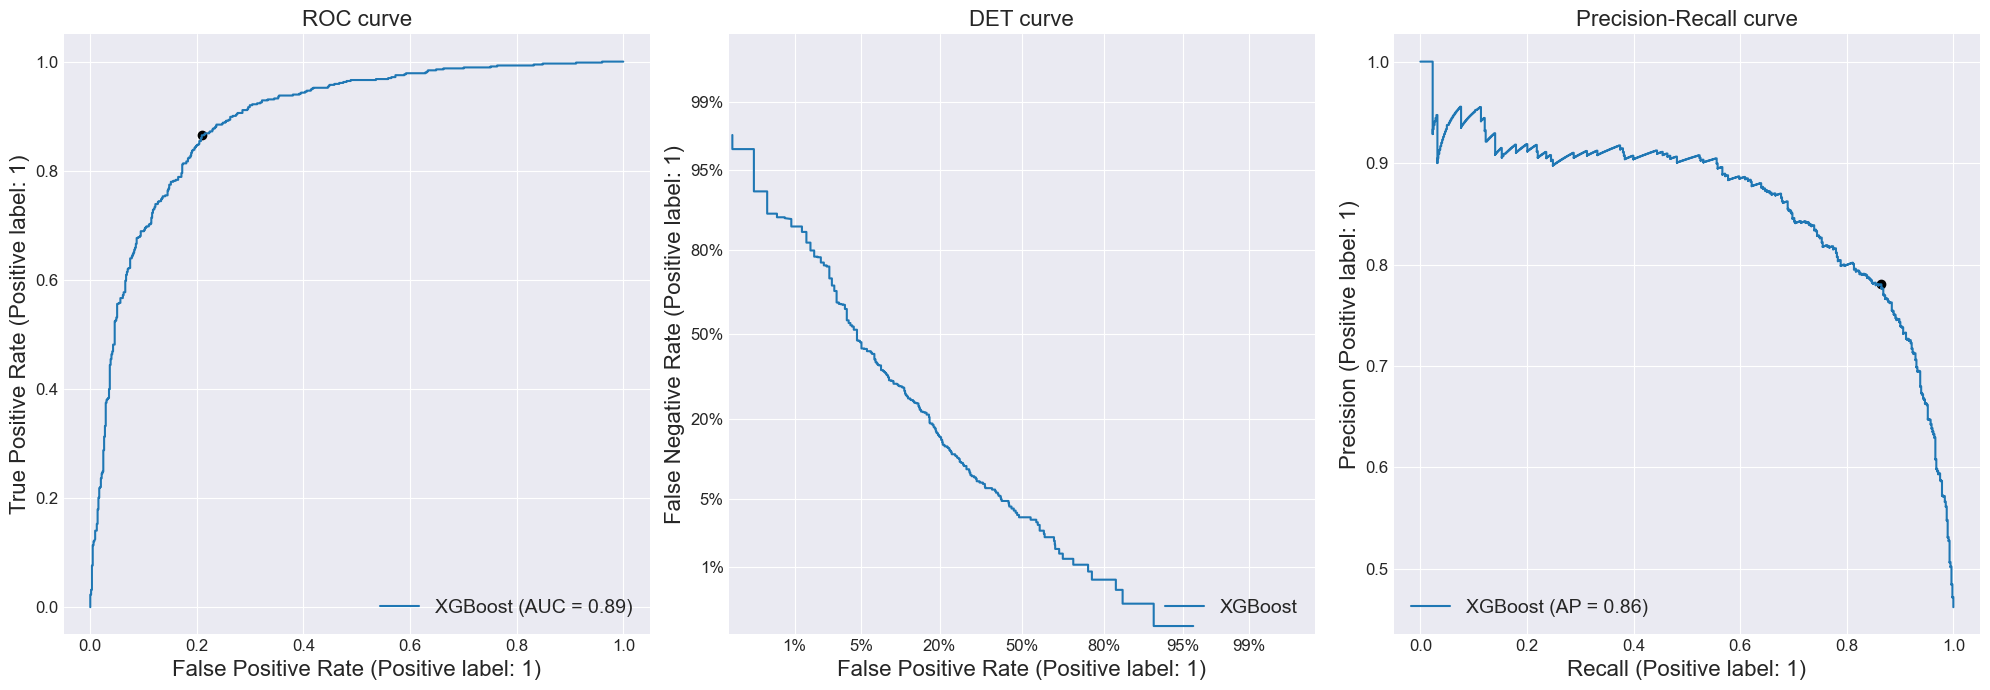

In [106]:
compare_metric_curves(
    {
        "XGBoost" : xgboost_1_best_y_pred_proba
    },
    datasets["val"]["Y"],
)

## Best 

In [117]:
pd.read_csv(f"optimization/{task}/best.csv", comment="#").sort_values("val_mcc", ascending=False)


,model,val_accuracy,val_f1,val_mcc,false_negative_rate,false_positive_rate
0,SVC,0.83,0.82,0.66,0.14,0.20
5,XGBoost_1,0.82,0.82,0.65,0.13,0.22
1,RandomForest,0.82,0.80,0.64,0.19,0.19
2,LogisticRegression,0.81,0.80,0.63,0.17,0.21
3,CatBoost,0.82,0.82,0.63,0.10,0.26
4,KNN,0.77,0.73,0.54,0.31,0.16
